In [57]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import tensorflow
import numpy as np

from gensim.models import Word2Vec as w2v


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load and Shuffle Data

In [41]:
train_df = pd.read_csv("training_data.csv")
train_df['Sentiment'] = train_df['Sentiment'].replace({'Positive': 1, 'Negative': 0})

In [42]:
# Shuffle the data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Word2Vec Model (random parameters)

In [43]:
sentences = [row.split() for row in train_df["Text"]] # get list of sentences
w2v_model = w2v(sentences, vector_size=200, window=5, min_count=1, workers=4) # fit and save model
w2v_model.save("twitter_model.model")

# Text Preprocessing

In [49]:
def training_preprocessing(df, w2v_model, use_custom_pad, pad_length = 0):
    # Tokenize Data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df["Text"])
    sequences = tokenizer.texts_to_sequences(df["Text"])
    max_sequence_length = max([len(seq) for seq in sequences])
    
    # If using a custom pad length then set this to true and provide length otherwise its max sequence length
    if use_custom_pad == True:
        # Pad Sequences (ensures same length) and get training data
        X_train = pad_sequences(sequences, maxlen = pad_length)
        Y_train = df["Sentiment"].values
    else:
        pad_length = max_sequence_length
        # Pad Sequences (ensures same length) and get training data
        X_train = pad_sequences(sequences, maxlen = pad_length)
        Y_train = df["Sentiment"].values
        
    
    # Create Embedding Matrix from Word2Vec Model to use in first layer
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, w2v_model.vector_size))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.key_to_index:
            embedding_matrix[i] = w2v_model.wv[word]
            
    return tokenizer, embedding_matrix, X_train, Y_train, pad_length



In [50]:
tokenizer, embedding_matrix, X_train, Y_train, pad_length = training_preprocessing(train_df, w2v_model, use_custom_pad = False)

# Define and Fit the Model

In [53]:
reg_term = .001 
model = Sequential()
# inital embedding layer 
model.add(Embedding(input_dim = len(tokenizer.word_index) + 1,
                    output_dim = w2v_model.vector_size,
                        weights = [embedding_matrix],
                        input_length = pad_length,
                        trainable = False))
# 3 LSTM Layers decreasing in size and a dense output layer with dropout to prevent overfitting
model.add(LSTM(256, return_sequences = True, recurrent_regularizer=l2(reg_term)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences = True, recurrent_regularizer=l2(reg_term)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences = False, recurrent_regularizer=l2(reg_term)))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer = l2(reg_term)))

# default adam optimizer used with binary cross entropy loss
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

# early stopping added to further prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 163, 200)          4714600   
                                                                 
 lstm_12 (LSTM)              (None, 163, 256)          467968    
                                                                 
 dropout_8 (Dropout)         (None, 163, 256)          0         
                                                                 
 lstm_13 (LSTM)              (None, 163, 128)          197120    
                                                                 
 dropout_9 (Dropout)         (None, 163, 128)          0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 1)                

In [54]:
# Fit the model and save as history so you can graph loss later
# Only run this if you need to refit the model, otherwise just load it below
history = model.fit(
    X_train,  
    Y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,  
    callbacks=[early_stopping],
    shuffle=True  # Shuffle again to ensure randomization
)

Epoch 1/10
904/904 [==============================] - 506s 554ms/step - loss: 0.5389 - accuracy: 0.7542 - val_loss: 0.4935 - val_accuracy: 0.7662
Epoch 2/10
904/904 [==============================] - 524s 579ms/step - loss: 0.4703 - accuracy: 0.7781 - val_loss: 0.4860 - val_accuracy: 0.7755
Epoch 3/10
904/904 [==============================] - 523s 578ms/step - loss: 0.4531 - accuracy: 0.7886 - val_loss: 0.4641 - val_accuracy: 0.7834
Epoch 4/10
904/904 [==============================] - 512s 566ms/step - loss: 0.4417 - accuracy: 0.7953 - val_loss: 0.4523 - val_accuracy: 0.7904
Epoch 5/10
904/904 [==============================] - 497s 549ms/step - loss: 0.4281 - accuracy: 0.8033 - val_loss: 0.4523 - val_accuracy: 0.7882
Epoch 6/10
904/904 [==============================] - 511s 566ms/step - loss: 0.4160 - accuracy: 0.8092 - val_loss: 0.4392 - val_accuracy: 0.8010
Epoch 7/10
904/904 [==============================] - 498s 551ms/step - loss: 0.4016 - accuracy: 0.8197 - val_loss: 0.4281 -

In [59]:
model.save("LSTM_Model.keras") # Save the model

In [82]:
model = load_model("LSTM_Model.keras")

# Training Metrics

In [83]:
y_pred_train = model.predict(X_train)

1129/1129 [==============================] - 190s 165ms/step


In [84]:
y_pred_train = (y_pred_train > 0.5).astype("int32")
train_acc = accuracy_score(Y_train, y_pred_train)
train_acc


0.859843871110619

Text(0, 0.5, 'Loss')

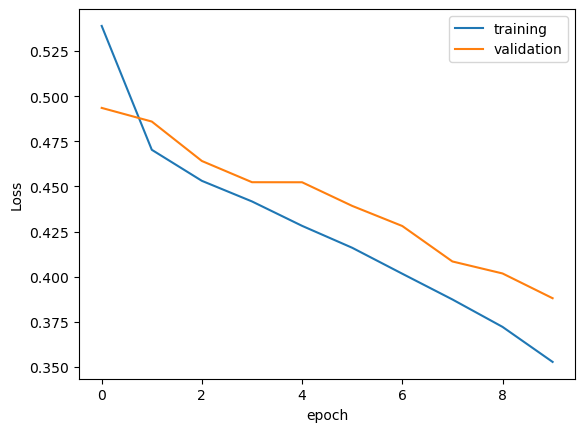

In [85]:
# Validation vs Training Loss Graph
training_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(training_loss, label = "training")
plt.plot(val_loss, label = "validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")

# Testing Metrics

In [86]:
test_df = pd.read_csv("testing_data.csv")
test_df['Sentiment'] = test_df['Sentiment'].replace({'Positive': 1, 'Negative': 0})

In [87]:
# Prepare test data same as training data
test_sequences = tokenizer.texts_to_sequences(test_df["Text"])
x_test = pad_sequences(test_sequences, maxlen = pad_length)
y_test = test_df["Sentiment"]

In [88]:
# get predictions and convert to binary
predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype("int32")

# accuracy 
test_acc = accuracy_score(y_test, predicted_classes)

# confustion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Precision 
prec = precision_score(y_test, predicted_classes)

#F1
f1 = f1_score(y_test, predicted_classes)

# Recall
rec = recall_score(y_test, predicted_classes)



17/17 [==============================] - 3s 175ms/step


In [89]:
print("Testing Metrics:")
print(f"Testing Accuracy: {test_acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")
print("Confusion Matrix: ")
print(cm)

Testing Metrics:
Testing Accuracy: 0.8775510204081632
Precision: 0.8913857677902621
Recall: 0.8654545454545455
F1 Score: 0.8782287822878229
Confusion Matrix: 
[[235  29]
 [ 37 238]]


In [90]:
orig_sentence = "" # enter sentence to get sentiment
sentence = tokenizer.texts_to_sequences([orig_sentence])
pad_sentence = pad_sequences(sentence, maxlen = 100)

pred = model.predict(pad_sentence)

if pred[0][0] >= .5:
    sentiment = "Positive :)"
else:
    sentiment = "Negative :("
    
print(sentiment)
print(orig_sentence)

1/1 [==============================] - 1s 910ms/step
Positive :)

